In [41]:
import gymnasium as gym
import numpy as np

import utils.plots_cliffwalking as plots

from env.cliff_walking import WindyCliffWalking
from importlib import reload

# Resolvendo o ambiente Cliff Walking com QLearning tabular

O [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) é um dos mais simples ambientes de aprendizado por reforço (RL), sendo ideal para entender o funcionamento do QLearning tabular, um dos algoritmos mais fundamentais para iniciantes. A ideia do Cliff Walking é simples: o agente deve ser capaz de atravessar um tabuleiro do início ao fim tomando cuidado para não cair em um penhasco. Se o agente cair no penhasco, ele retorna para o início do tabuleiro e leva uma penalidade de recompensa.

<img src="media/cliff_walking.gif" width="200">

Abaixo seguem algumas informações importantes para a modelagem do ambiente como um Processo de Decisão de Markov (MDP):

### Espaço de ações

O espaço de ações é discreto e contém os inteiros do intervalo {0, 3}. Uma ação deve indicar a direção de um movimento:
* 0: Cima
* 1: Direita
* 2: Baixo
* 3: Esquerda

### Espaço de estados

O estado representa a posição do jogador no tabuleiro. Logo, o espaço de estados também é discreto e contém os inteiros do intervalo {0, 47}. O valor numérico da posição do agente no tabuleiro pode ser obtido como linha_atual * nlinhas + coluna, sendo que as linhas e colunas começam em 0.



In [58]:
cliff_walking = WindyCliffWalking(wind=0.3)

### Criando a tabela de QValores

A tabela de Qvalores recebe como entrada um par (estado, ação) e deve retornar o QValor desse par. Um QValor pode ser interpretado como "a recompensa acumulada total esperada por executar a ação A no estado S e depois seguir a mesma política até o final do episódio". Logo, devemos ter uma linha da tabela para cada um dos 48 estados, sendo que cada linha deve ter uma coluna para cada uma das 4 ações. Além disso, os QValores devem possuir um valor inicial preferencialmente diferente de zero.

<figure>
    <img src="media/qtable.png" alt="sample qtable" width="400">
    <figcaption> Exemplo de tabela de Qvalores. Fonte: <a href="https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial"> Datacamp </a> </figcaption>
</figure>

In [43]:
def new_q_table(n_states, n_actions):
    return np.full((n_states, n_actions), 0.1)

### Amostrando ações com a política $\epsilon$-greedy

No final do treinamento, espera-se que a melhor ação para cada estado seja aquela cujo QValor é o maior. No entanto, para que o QLearn convirja adequadamente, é necessário que no início do treinamento o agente "explore" bem o ambiente. Isto é, que ele visite um grande número de estados mesmo que não sejam necessariamente ótimos. Uma técnica amplamente utilizada para essa finalidade é a política $\epsilon$-greedy. Ela consiste em forçar o agente a escolher ações aleatoriamente com uma frequência que diminui conforme o treinamento avança.

In [44]:
def get_action(q_table, state, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(0, q_table.shape[1])
    return np.argmax(q_table[state])

### Atualização dos QValores utilizando a equação de Bellman

A cada passo do treinamento, o agente executará uma ação e utilizará a informação retornada pelo ambiente para atualizar os seus QValores e, assim, aprender a tabela ótima. A atualização dos seus QValores é realizada através da equação de Bellman:

$$Q_{t+1}(s_t, a_t) = (\alpha - 1) Q_t (s_t, a_t) + \alpha (R_{t+1} + \gamma \max_{a} Q_t (s_{t+1}, a))$$

In [45]:
def update_q_table(q_table, state, action, reward, next_state, terminated, alpha, gamma):
    if terminated:
        q_table[next_state] = np.zeros(q_table.shape[1]) # a recompensa esperada para o estado terminal é 0

    q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state]))
    return q_table

### Loop de treinamento

No loop de treinamento, juntaremos todas as funções desenvolvidas até o momento. A ideia principal é definir um número máximo de episódios (estágio inicial até o estágio final) para que o agente colete experiências do ambiente e otimize sua tabela de QValores.

In [46]:
def train(env: gym.Env, 
          q_table,
          n_episodes=5000, 
          epsilon=0.99, 
          epsilon_decay=0.999, 
          alpha=0.75, 
          gamma=0.99):
     
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        step = 0
        done = False

        if epsilon > 0.001:
            epsilon *= epsilon_decay
        
        while not done and step < 500: # 1000 steps max
            action = get_action(q_table, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            q_table = update_q_table(q_table, state, action, reward, next_state, terminated, alpha, gamma)
            state = next_state
            total_reward += reward

            done = terminated or truncated
            step += 1
            
        if episode % 100 == 0:
            print(f"Episode {episode} - Total reward: {total_reward} - epsilon: {epsilon}")

    return q_table

### Treinando

In [59]:
q_table = new_q_table(n_states=48, n_actions=4)
trained_q_table = train(cliff_walking, q_table, alpha=0.75)

Episode 0 - Total reward: -8024 - epsilon: 0.98901
Episode 100 - Total reward: -7331 - epsilon: 0.8948484814169296
Episode 200 - Total reward: -7034 - epsilon: 0.8096518788426657
Episode 300 - Total reward: -5549 - epsilon: 0.7325666618727043
Episode 400 - Total reward: -4460 - epsilon: 0.6628205628997266
Episode 500 - Total reward: -1543 - epsilon: 0.5997148402571608
Episode 600 - Total reward: -361 - epsilon: 0.5426172779722319
Episode 700 - Total reward: -134 - epsilon: 0.4909558519974922
Episode 800 - Total reward: -250 - epsilon: 0.4442129994668515
Episode 900 - Total reward: -352 - epsilon: 0.40192043356343343
Episode 1000 - Total reward: -25 - epsilon: 0.3636544520527319
Episode 1100 - Total reward: -903 - epsilon: 0.3290316924802508
Episode 1200 - Total reward: -30 - epsilon: 0.2977052915076636
Episode 1300 - Total reward: -27 - epsilon: 0.26936140991033175
Episode 1400 - Total reward: -22 - epsilon: 0.24371608842234507
Episode 1500 - Total reward: -250 - epsilon: 0.22051240292

### Testando o agente

In [48]:
def test(render_env: gym.Env, 
          q_table,
          n_episodes=1
          ):
     
    for episode in range(n_episodes):
        state, _ = render_env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = get_action(q_table, state, 0)
            state, reward, terminated, truncated, _ = render_env.step(action)
            total_reward += reward

            done = terminated or truncated

        print(f"Episode {episode} - Total reward: {total_reward}")

    render_env.close()

#test(WindyCliffWalking(0.3, render_mode="human"), trained_q_table) # descomente essa rede para ver a execução do agente treinado

### Análise de resultados

In [60]:
q_table

array([[-1.59045442e+01, -1.34712881e+01, -1.60684834e+01,
        -1.59666349e+01],
       [-1.44324437e+01, -1.24479695e+01, -1.53315272e+01,
        -1.47317490e+01],
       [-1.29644136e+01, -1.13085774e+01, -1.29866790e+01,
        -1.38974393e+01],
       [-1.12464036e+01, -1.01176622e+01, -1.25224272e+01,
        -1.23425523e+01],
       [-1.04678941e+01, -9.07828768e+00, -1.14848399e+01,
        -1.08191560e+01],
       [-9.48515288e+00, -8.32456126e+00, -1.06662261e+01,
        -9.84880505e+00],
       [-7.66892854e+00, -6.40704660e+00, -9.89961513e+00,
        -8.57565739e+00],
       [-7.52305762e+00, -5.27576752e+00, -6.99638804e+00,
        -7.61663051e+00],
       [-5.91365458e+00, -4.67437719e+00, -6.27809304e+00,
        -6.98671937e+00],
       [-4.84111984e+00, -3.30375107e+00, -4.89036168e+00,
        -5.89318959e+00],
       [-4.29967689e+00, -3.07124535e+00, -3.92367938e+00,
        -4.80803240e+00],
       [-3.18817901e+00, -3.09901555e+00, -2.73978224e+00,
      

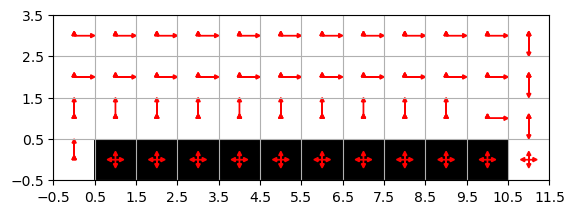

<Figure size 640x480 with 0 Axes>

In [61]:
# arrow plot
reload(plots)
plots.plot_arrows(trained_q_table)

In [ ]:
# retorno médio esperado em função de alpha

### Exercício - estocasticidade